# Metadata

```
Name: Maureen O'Shea (mo2cr@virginia.edu)
Course: DS5001
Date: 06 May 2022

Title: Word2Vec Word Embeddings

Description: We create our own word embeddings with play data using word2vec and visualize results with tSNE

Original Code Author: R.C. Alvarado, Module 09 Lab, We create our own word embeddings with novel data using word2vec and visualize results with tSNE.
```

# Set Up

In [1]:
data_home = './data'
data_prefix = 'folger'

In [2]:
OHCO = ['play_code', 'act_num', 'scene_num', 'speech_id', 'speaker','line_num']

In [3]:
w2v_params = dict(
    min_count = 10,
    workers = 4,
    # vector_size = 246,
    vector_size = 100,
    window = 2    
)

In [4]:
tsne_params = dict(
    learning_rate = 200., #'auto' or [10.0, 1000.0]
    perplexity = 40,
    n_components = 2,
    init = 'random',
    n_iter = 1000,
    random_state = 23    
)

In [5]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

# Get Data

In [6]:
TOKEN = pd.read_csv(f'{data_home}/folger-TOKEN2.csv', low_memory=False).set_index(OHCO).dropna()

In [7]:
TOKEN.head(10)

token_str  lemma  \
play_code act_num scene_num speech_id speaker line_num                    
1H4       1       1         1         henryiv 1               So     so   
                                              1           shaken  shake   
                                              1               as     as   
                                              1               we     we   
                                              1              are     be   
                                              1               so     so   
                                              1              wan    wan   
                                              1             with   with   
                                              1             care   care   
                                              2             Find   find   

                                                           pos term_str  
play_code act_num scene_num speech_id speaker line_num                   
1H4       1       1         1         henryiv 1             av       so  
                                              1            vvn   shaken  
                                              1         acp-cs       as  
                                              1            pns       we  
                                              1            vvb      are  
                                              1             av       so  
                                              1              j      wan  
                                              1          acp-p     with  
                                              1             n1     care  
                                              2            vvb     find

# Extract VOCAB

Use this to filter significant terms and to store w2v features and tSNE coordinates.

In [8]:
VOCAB = TOKEN.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'

In [9]:
VOCAB['pos_max'] = TOKEN.value_counts(['term_str','pos']).unstack().idxmax(1)

In [10]:
VOCAB['pos_group'] = VOCAB.pos_max.str.slice(0,2)

In [11]:
VOCAB

,n,pos_max,pos_group
term_str,,,
the,18480,d,d
and,18452,cc,cc
to,13936,acp-cs,ac
i,13845,pns,pn
of,11543,acp-p,ac
...,...,...,...
lubber,1,n1,n1
undividable,1,j,j
waterrugs,1,n2,n2


# Add ACTS Significance

In [12]:
ACTS = TOKEN.groupby(OHCO[:2]+['term_str']).term_str.count()\
    .unstack(fill_value=0).astype('bool').astype('int')

In [13]:
ACTS.head()

term_str           a  aaron  aarons  abandon  abandoned  abandonèd  abase  \
play_code act_num                                                           
1H4       1        1      0       0        0          0          0      0   
          2        1      0       0        0          0          0      0   
          3        1      0       0        0          0          0      0   
          4        1      0       0        0          0          0      0   
          5        1      0       0        0          0          0      0   

term_str           abashed  abate  abated  ...  zeal  zealous  zenith  \
play_code act_num                          ...                          
1H4       1              0      0       0  ...     0        0       0   
          2              0      0       0  ...     0        0       0   
          3              0      0       0  ...     0        0       0   
          4              0      0       0  ...     0        0       0   
          5              0      0       0  ...     0        0       0   

term_str           zephyrs  zodiac  zodiacs  zone  zounds  à  ô  
play_code act_num                                                
1H4       1              0       0        0     0       0  0  0  
          2              0       0        0     0       0  0  0  
          3              0       0        0     0       0  0  0  
          4              0       0        0     0       0  0  0  
          5              0       0        0     0       0  0  0  

[5 rows x 22058 columns]

In [14]:
VOCAB['df'] = ACTS.sum()
VOCAB['dfidf'] = VOCAB.df * np.log2(len(ACTS)/VOCAB.df)

In [15]:
VOCAB.sort_values('dfidf', ascending=False)

,n,pos_max,pos_group,df,dfidf
term_str,,,,,
entreat,98,vvi,vv,68,98.186466
highness,177,n1,n1,68,98.186466
note,107,n1,n1,68,98.186466
favor,102,n1,n1,68,98.186466
tomorrow,160,av_n,av,68,98.186466
...,...,...,...,...,...
no,2535,d-x,d-,184,1.438789
the,18480,d,d,184,1.438789
and,18452,cc,cc,185,0.000000


# Get List of Token Lists

Because that's what Gensim wants.

In [16]:
SENTS = TOKEN.groupby(OHCO[:6]).term_str.apply(lambda  x:  x.tolist())

In [17]:
SENTS

play_code  act_num  scene_num  speech_id  speaker       line_num
1H4        1        1          1          henryiv       1              [so, shaken, as, we, are, so, wan, with, care]
                                                        2           [find, we, a, time, for, frighted, peace, to, ...
                                                        3           [and, breathe, shortwinded, accents, of, new, ...
                                                        4              [to, be, commenced, in, strands, afar, remote]
                                                        5           [no, more, the, thirsty, entrance, of, this, s...
                                                                                          ...                        
Wiv        5        5          2903       mistresspage  250         [and, laugh, this, sport, oer, by, a, country,...
                                                        251                                     [sir, john, a

# Learn Word Embeddings

In [18]:
#SENTS.head().tolist()

In [19]:
model = word2vec.Word2Vec(SENTS.values, **w2v_params)

In [20]:
W2V = pd.DataFrame(model.wv.get_normed_vectors(), index=model.wv.index_to_key)
W2V.index.name = 'term_str'
W2V = W2V.sort_index()

In [21]:
W2V.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
term_str,,,,,,,,,,,,,,,,,,,,,
a,-0.004598,-0.026435,0.172445,0.081749,-0.224106,-0.017249,0.029265,-0.090902,-0.133778,0.051412,...,0.058756,-0.040717,-0.150032,0.056467,-0.063284,0.101624,0.154379,-0.128923,0.014361,-0.096609
aaron,-0.072001,0.030680,0.009165,-0.015613,-0.034472,-0.118283,0.003473,0.246472,-0.124569,-0.118178,...,0.204128,0.121338,0.018897,0.003393,0.218155,0.094292,0.056597,-0.091558,0.065695,0.007104
abbey,-0.061445,0.009274,-0.033832,0.008687,0.006175,-0.040050,0.076695,0.254748,-0.186954,-0.087655,...,0.241894,0.029804,0.018534,-0.009977,0.191810,0.141904,0.021922,-0.045788,0.092863,0.001910
abhor,-0.097406,0.095749,0.011732,0.029304,0.009816,-0.121323,0.067266,0.239851,-0.187955,-0.099918,...,0.177069,0.114527,-0.011441,0.072079,0.257158,0.129416,0.064927,-0.114341,-0.039141,0.041109
abhorred,-0.125501,0.041470,-0.031108,-0.043862,0.019984,-0.077121,0.041469,0.245292,-0.169660,-0.064311,...,0.169148,0.094981,0.018229,0.019847,0.202733,0.119206,0.117379,-0.091248,0.055769,0.075527


# Visualize with tSNE

In [22]:
tsne_engine = TSNE(**tsne_params)
tsne_model = tsne_engine.fit_transform(W2V)

In [23]:
COORDS = pd.DataFrame(tsne_model, columns=['x','y'], index=W2V.index)\
    .join(VOCAB, how='left')[['x','y','n','dfidf','pos_group']]

In [24]:
COORDS

,x,y,n,dfidf,pos_group
term_str,,,,,
a,44.025097,8.290555,8527,0.000000,d
aaron,-10.644180,-26.940971,24,17.839257,n1
abbey,-1.484880,-11.384762,14,26.047267,n1
abhor,-24.424381,-21.326120,13,47.357028,vv
abhorred,2.240479,-3.148460,11,44.791448,j_
...,...,...,...,...,...
yourselves,-19.951767,-29.103872,61,89.840690,px
youth,-1.239814,54.511826,188,92.719394,n1
youthful,21.756184,5.730505,26,67.582897,j


In [25]:
px.scatter(COORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')


/Users/maureenoshea/opt/anaconda3/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



In [26]:
px.scatter(COORDS.reset_index().sort_values('dfidf', ascending=False).head(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [27]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [28]:
complete_analogy('king', 'man', 'queen', 5)

,term,sim
0,woman,0.823813
1,maid,0.803771
2,word,0.800276
3,little,0.799389
4,soldier,0.797357


In [29]:
complete_analogy('girl', 'sister', 'boy', 3)

,term,sim
0,brother,0.865154
1,husband,0.857206
2,mistress,0.830918


In [30]:
complete_analogy('minute', 'second', 'day', 5)

,term,sim
0,sun,0.843458
1,moon,0.828675
2,law,0.822411
3,sea,0.816865
4,same,0.816725


In [31]:
complete_analogy('nurse', 'doctor', 'woman', 5)

,term,sim
0,thing,0.935395
1,maid,0.872220
2,man,0.861210
3,strange,0.856791
4,almost,0.850448


## Similarites

In [32]:
get_most_similar('fool')

,term,sim
0,traitor,0.932567
1,soldier,0.932257
2,slave,0.926258
3,maid,0.925050
4,woman,0.921583
5,gentleman,0.915556
6,ass,0.903167
7,thing,0.902652
8,devil,0.894087
9,villain,0.886864


In [33]:
get_most_similar('king')

,term,sim
0,queen,0.784113
1,henry,0.765808
2,richard,0.763824
3,prince,0.752767
4,last,0.722701
5,ring,0.715120
6,duke,0.714128
7,truth,0.712102
8,moor,0.711598
9,child,0.710824


In [34]:
get_most_similar('queen')

,term,sim
0,mistress,0.914449
1,prince,0.895013
2,child,0.894257
3,letter,0.880271
4,daughter,0.876349
5,lady,0.875868
6,mother,0.869984
7,husband,0.868852
8,master,0.867792
9,son,0.866412


In [35]:
get_most_similar('sword')

,term,sim
0,lips,0.927124
1,soul,0.926844
2,tongue,0.922159
3,body,0.920326
4,life,0.904575
5,knee,0.902586
6,conscience,0.899419
7,face,0.897880
8,horse,0.897811
9,sight,0.897410


In [36]:
get_most_similar('happy')

,term,sim
0,strange,0.941342
1,certain,0.918816
2,needful,0.914800
3,virtuous,0.913441
4,just,0.911924
5,honorable,0.905180
6,weak,0.903985
7,dangerous,0.903834
8,precious,0.902550
9,valiant,0.901238


In [37]:
get_most_similar('sad')

,term,sim
0,contented,0.959870
1,slack,0.957372
2,safe,0.953202
3,merciful,0.952255
4,theirs,0.949626
5,wheer,0.946261
6,calm,0.943283
7,abroad,0.942920
8,paid,0.942555
9,blest,0.940168


In [38]:
get_most_similar(positive=['happy'], negative=['sad'])

,term,sim
0,most,0.444804
1,of,0.420895
2,thousand,0.419288
3,day,0.413358
4,poor,0.404159
5,thing,0.389251
6,very,0.383486
7,great,0.377980
8,th,0.377047
9,was,0.369485


In [39]:
get_most_similar(positive='woman')

,term,sim
0,fool,0.962389
1,maid,0.957831
2,man,0.933518
3,thing,0.932648
4,soldier,0.912643
5,gentleman,0.907463
6,little,0.862162
7,whit,0.860652
8,villain,0.850206
9,deed,0.849732


# Save

In [46]:
W2V.to_csv(f'{data_home}/{data_prefix}-W2V.csv')
VOCAB.to_csv(f'{data_home}/{data_prefix}-W2V_VOCAB.csv')
SENTS.to_csv(f'{data_home}/{data_prefix}-GENSIM_DOCS.csv')

# Experiment: W2V Features as Topics

In [48]:
W2V.describe().T.style.background_gradient(cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
0,4242.000000,-0.080022,0.063810,-0.299217,-0.119878,-0.091159,-0.052783,0.227930
1,4242.000000,0.052400,0.065973,-0.352030,0.011618,0.044576,0.086714,0.329417
2,4242.000000,-0.002600,0.039255,-0.221325,-0.023242,-0.001338,0.018840,0.272631
3,4242.000000,-0.005466,0.041889,-0.204470,-0.030702,-0.009502,0.015933,0.244836
4,4242.000000,0.014635,0.051454,-0.258962,-0.014620,0.011965,0.040073,0.332287
5,4242.000000,-0.105931,0.046403,-0.253535,-0.136260,-0.111440,-0.082227,0.136881
6,4242.000000,0.024308,0.036047,-0.250630,0.003960,0.022382,0.042091,0.221032
7,4242.000000,0.229154,0.040409,-0.087910,0.219444,0.237102,0.252622,0.322890
8,4242.000000,-0.127173,0.036360,-0.223314,-0.151437,-0.133564,-0.111296,0.083372
9,4242.000000,-0.089790,0.036133,-0.222216,-0.110635,-0.092663,-0.074555,0.160774


In [49]:
VSIGS = VOCAB.sort_values('dfidf').tail(1000)

In [50]:
W2Vp = (W2V - W2V.min()) #[0].sort_values().plot()
W2Vp = W2Vp.loc[VSIGS.index]
W2Vp = W2Vp / W2Vp.sum()

In [51]:
# W2Vp[0].sort_values(ascending=False).head(100).plot()

In [52]:
topics = []
for i in W2Vp.columns:
    top_words = ' '.join(W2V.sort_values(i, ascending=False).index[:10])
    print(i, top_words)
    topics.append((i, top_words))

0 could you cannot none would they but them god must
1 when saw though while thank told since say loved please
2 he she who far caesar been much long it himself
3 that this himself which heaven first he the then france
4 to away ill up leave pray forth beseech will off
5 king day here hour sun crown head into world field
6 any can once world heard gods first heaven rather place
7 friar polixenes buckingham nurse cassio kate luck midst richard desdemona
8 o tis night day hour son be like lady most
9 when where which more till at how upon than though
10 tis i word am theres are well doubt do friend
11 we i they at by how from on give eyes
12 king he she who ever hast i father so most
13 our rome come padua ourselves this him thursday london thence
14 i why kill tell make prove yield grant find call
15 lord lady too where prince done how queen son made
16 own honor eyes ear eye grace enemies ears age lordship
17 let home leave back hither lets to near bid welcome
18 noble fair fares many 

<AxesSubplot:xlabel='term_str'>

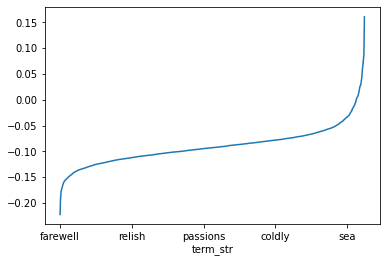

In [53]:
W2V[9].sort_values().plot()

<AxesSubplot:>

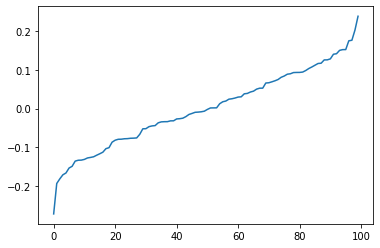

In [54]:
W2V.iloc[0].sort_values().reset_index(drop=True).plot()